In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import patsy
import sys
import numpy.linalg as la
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from matplotlib import style
from sklearn.decomposition import PCA
from sklearn import cluster, preprocessing, manifold
from sklearn.preprocessing import StandardScaler

In [2]:
def design_mat(mod, numerical_covariates, batch_levels):
    design = patsy.dmatrix("~ 0 + C(batch, levels=%s)" % str(batch_levels),
                                                  mod, return_type="dataframe")

    mod = mod.drop(["batch"], axis=1)
    numerical_covariates = list(numerical_covariates)
    sys.stderr.write("found %i batches\n" % design.shape[1])
    other_cols = [c for i, c in enumerate(mod.columns)
                  if not i in numerical_covariates]
    factor_matrix = mod[other_cols]
    design = pd.concat((design, factor_matrix), axis=1)
    if numerical_covariates is not None:
        sys.stderr.write("found %i numerical covariates...\n"
                            % len(numerical_covariates))
        for i, nC in enumerate(numerical_covariates):
            cname = mod.columns[nC]
            sys.stderr.write("\t{0}\n".format(cname))
            design[cname] = mod[mod.columns[nC]]
    sys.stderr.write("found %i categorical variables:" % len(other_cols))
    sys.stderr.write("\t" + ", ".join(other_cols) + '\n')
    return design

In [3]:
def aprior(gamma_hat):
    m = gamma_hat.mean()
    s2 = gamma_hat.var()
    return (2 * s2 +m**2) / np.float64(s2)

In [4]:
def bprior(gamma_hat):
    m = gamma_hat.mean()
    s2 = gamma_hat.var()
    return (m*s2+m**3) / np.float64(s2)

In [5]:
def postmean(g_hat, g_bar, n, d_star, t2):
    return (t2*n*g_hat+d_star * g_bar) / (t2*n+d_star)

In [6]:
def postvar(sum2, n, a, b):
    return (0.5 * sum2 + b) / (n / 2.0 + a - 1.0)

In [7]:
def it_sol(sdat, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001):
    n = (1 - np.isnan(sdat)).sum(axis=1)
    g_old = g_hat.copy()
    d_old = d_hat.copy()

    change = 1
    count = 0
    while change > conv:
        
        g_new = postmean(g_hat, g_bar, n, d_old, t2)
        sum2 = ((sdat - np.dot(g_new.reshape((g_new.shape[0], 1)), np.ones((1, sdat.shape[1])))) ** 2).sum(axis=1)
        d_new = postvar(sum2, n, a, b)
       
        change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
        g_old = g_new 
        d_old = d_new 
        count = count + 1
    adjust = (g_new, d_new)
    return adjust

In [8]:
def it_sol_loc(g_hat, g_bar, n, d_hat, t2):
    n = 1
    g_old = g_hat.copy()
    d_old = d_hat.copy()

    g_new = postmean(g_hat, g_bar, n, d_old, t2)
    g_old = g_new 
    adjust = (g_new)
    return adjust

In [9]:
def it_sol_scale(sdat, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001):
    n = (1 - np.isnan(sdat)).sum(axis=1)
    g_old = g_hat.copy()
    d_old = d_hat.copy()

    change = 1
    count = 0
    while change > conv:
        g_new = postmean(g_hat, g_bar, n, d_old, t2)
        sum2 = ((sdat - np.dot(g_new.reshape((g_new.shape[0], 1)), np.ones((1, sdat.shape[1])))) ** 2).sum(axis=1)
        d_new = postvar(sum2, n, a, b)
       
        change = (abs(d_new - d_old) / d_old).max()
        g_old = g_new 
        d_old = d_new 
        count = count + 1
    adjust = (d_new, g_new)
    return adjust

In [10]:
def combat(data, batch, model=None, numerical_covariates=None, mean_only=False, ref_batch=None):
    """Correct for batch effects in a dataset
    Parameters
    ----------
    data : pandas.DataFrame
        A (n_features, n_samples) dataframe of the expression to batch correct
    batch : List-like
        A column corresponding to the batches in the data, in the same order
        as the samples in ``data``
    model : patsy.design_info.DesignMatrix, optional
        A model matrix describing metadata on the samples which could be
        causing batch effects. If not provided, then will attempt to coarsely
        correct just from the information provided in ``batch``
    numerical_covariates : list-like
        List of covariates in the model which are numerical, rather than
        categorical
    mean_only : (T/F)
        Only adjusts for mean across the batches, forgoing scale (variance) adjustment. 
        Default = False
    ref_batch : int
        Adjusts all batches to the specified reference batch. Specified batch will not be adjusted.
        Default = None
        
    Returns
    -------
    corrected : pandas.DataFrame
        A (n_features, n_samples) dataframe of the batch-corrected data
    """
    if isinstance(numerical_covariates, str):
        numerical_covariates = [numerical_covariates]
    
    if numerical_covariates is None:
        numerical_covariates = []

    if model is not None and isinstance(model, pd.DataFrame):
        model["batch"] = list(batch)
    
    else:
        model = pd.DataFrame({'batch': batch})
        
    if ref_batch is not None and isinstance(ref_batch, int):
        ref = int(ref_batch)

    batch_items = model.groupby("batch").groups.items()
    batch_levels = [k for k, v in batch_items]
    batch_info = [v for k, v in batch_items]
    n_batch = len(batch_info)
    n_batches = np.array([len(v) for v in batch_info])
    n_array = sum(n_batches)
    
    drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
    drop_idxs = [list(model.columns).index(cdrop) for cdrop in drop_cols]
    model = model[[c for c in model.columns if not c in drop_cols]]
    numerical_covariates = [list(model.columns).index(c) if isinstance(c, str) else c
            for c in numerical_covariates if not c in drop_cols]
    
    design = design_mat(model, numerical_covariates, batch_levels)
    
    if ref_batch is not None:
        design.iloc[:,ref-1] = 1.
    
    sys.stderr.write("Standardizing Data across genes.\n")
    B_hat = np.dot(np.dot(la.inv(np.dot(design.T, design)), design.T), data.T)
    
    #If using covariates from 'dft', drop in refdat line.
    if ref_batch is not None:
        grand_mean = B_hat[ref-1]
        refdat = dft.loc[dft['batch'] == ref].drop('batch', axis=1)
        reflist=refdat.index.tolist()
        desbatch=design.T[reflist].T
        var_pooled = np.dot(((refdat - np.dot(desbatch, B_hat))**2).T, np.ones((n_batches[ref-1], 1)) / n_batches[ref-1])
            
    else:
        grand_mean = np.dot((n_batches / n_array).T, B_hat[:n_batch,:])
        var_pooled = np.dot(((data - np.dot(design, B_hat).T)**2), np.ones((n_array, 1)) / n_array)

    stand_mean = np.dot(grand_mean.T.reshape((len(grand_mean), 1)), np.ones((1, n_array)))
    tmp = np.array(design.copy())
    tmp[:,:n_batch] = 0
    stand_mean  += np.dot(tmp, B_hat).T
    
    s_data = ((data - stand_mean) / np.dot(np.sqrt(var_pooled), np.ones((1, n_array))))

    sys.stderr.write("Fitting L/S model and finding priors\n")
    batch_design = design[design.columns[:n_batch]]
    gamma_hat = np.dot(np.dot(la.inv(np.dot(batch_design.T, batch_design)), batch_design.T), s_data.T)

    delta_hat = []

    for i, batch_idxs in enumerate(batch_info):
        if mean_only is False:
            delta_hat.append(s_data[batch_idxs].var(axis=1))
        
        else:
            x=s_data[batch_idxs].var(axis=1)
            x[x<100]=1
            np.float64(delta_hat.append(x))
            
    gamma_bar = gamma_hat.mean(axis=1) 
    t2 = gamma_hat.var(axis=1)
    
    a_prior = list(map(aprior, delta_hat))
    b_prior = list(map(bprior, delta_hat))
    
    sys.stderr.write("Finding parametric adjustments\n")
    
    gamma_star, delta_star = [], []
    for i, batch_idxs in enumerate(batch_info):
    
        if mean_only is False:
            
            temp = it_sol(s_data[batch_idxs], gamma_hat[i],
            delta_hat[i], gamma_bar[i], t2[i], a_prior[i], b_prior[i])

            gamma_star.append(temp[0])
            delta_star.append(temp[1])
        
        else:
            
            temploc = it_sol_loc(gamma_hat[i], gamma_bar[i], 1, delta_hat[i], t2[i])

            gamma_star.append(temploc)
        
            tempscale = it_sol_scale(s_data[batch_idxs], gamma_hat[i],
                     delta_hat[i], gamma_bar[i], t2[i], a_prior[i], b_prior[i])
        
            y=tempscale[1]
            y[y<100]=1
            delta_star.append(y)
    
    sys.stdout.write("Adjusting data\n")
    bayesdata = s_data
    gamma_star = np.array(gamma_star)
    delta_star = np.array(delta_star)
    
    if ref_batch is not None:
        gamma_star[ref-1]=0
        delta_star[ref-1]=1

    for j, batch_idxs in enumerate(batch_info):

        dsq = np.sqrt(delta_star[j,:])
        dsq = dsq.reshape((len(dsq), 1))
        denom =  np.dot(dsq, np.ones((1, n_batches[j])))
        numer = np.array(bayesdata[batch_idxs] - np.dot(batch_design.ix[batch_idxs], gamma_star).T)

        bayesdata[batch_idxs] = numer / denom
   
    vpsq = np.sqrt(var_pooled).reshape((len(var_pooled), 1))
    bayesdata = bayesdata * np.dot(vpsq, np.ones((1, n_array))) + stand_mean
   
    return bayesdata

In [11]:
df=pd.read_table('../Data/Python_Data/meta_mRNA.txt',index_col=0,skiprows=0)
df=df.iloc[1:,:]
df=df.T
df=df.applymap(lambda x: float(x))
df=(df-df.mean())/df.std()
df=df.T
def load_data_rna(type='rna'):
    path='../Data/Python_Data/RNA_fpkm_short.txt'
    df=pd.read_csv(path,sep='\t')
    df.columns=['Sample','Gene','FPKM']
    df=df.pivot_table(index='Gene',columns='Sample',values='FPKM')
    df.columns=df.columns.map(lambda x: x.split('_')[1])
    A=df.transpose().sum().sort_values(ascending=False)
    s=A[A>1].index
    df=df.loc[s]
    del df.columns.name
    del df.index.name
    return df
dfr=load_data_rna()
dfr.columns=dfr.columns.map(lambda x: 'Columbia.'+x)

dfr2=pd.read_excel('../Data/Python_Data/Columbia_Cohort2_fpkm.xlsx',index_col=0)
dfr2.columns=dfr2.columns.map(lambda x: 'Columbia2.'+x)
del dfr2.index.name



#Loading skin tissue for iorio paper (GDSC)
def load_iorio_skin():
        df=pd.read_csv('../Data/Python_Data/Cell_line_RMA_proc_basalExp.txt',sep='\t',index_col=0)
        del df.index.name
        del df['GENE_title']
        df.columns=df.columns.map(lambda x: x.split('DATA.')[1])
        #df.columns=df.columns.map(lambda x: x.split('.')[0])
        df=df.loc[pd.notnull(df.index)]
        df2=pd.read_excel('../Data/Python_Data/mmc2.xlsx',\
        sheetname='TableS1E-CellLines', sep='\t',skiprows=2,index_co1='Sample Name')
        dfs=pd.Series(df2['Sample Name'].values,df2['COSMIC identifier'].values)
        df.columns=df.columns.map(lambda x: float(x))
        df.columns=dfs.loc[df.columns].values
        return df
def load_iorio_tissue():
        df=pd.read_excel('../Data/Python_Data/mmc2.xlsx',\
           sheetname='TableS1E-CellLines', sep='\t',skiprows=2)
        df=df.iloc[1:-1]
        df.columns=['1','Sample','Cosmic','WES','CNA','GE','Methylation','Drugs','Type 1','Type 2','Cancer','MS instability','Medium','Growth']
        df=df[['Sample','Cosmic','WES','CNA','GE','Methylation','Drugs','Type 1','Type 2','Cancer','MS instability']]
        df=df.loc[(df['WES']=='Y') & (df['CNA']=='Y') & (df['GE']=='Y') & (df['Drugs']=='Y')
        & (df['Methylation']=='Y')]
        df.loc[df['Cancer']=='UNABLE TO CLASSIFY','Cancer']='Unclasified'
        df['Cancer']=df['Cancer'].fillna('Unclasified')
        df.index=df['Sample'].values
        return df
dfgeskin=load_iorio_skin()
dftissue=load_iorio_tissue()
dfs=dftissue['Type 1'][dfgeskin.columns]=='skin'
dfs=dfs[dfs].index
dfgeskin=dfgeskin.loc[:,dfs]
dfgeskin.columns=dfgeskin.columns.map(lambda x: 'skin.'+x)


df=pd.concat([df,np.log(dfr+1)],axis=1,join='inner')
df=pd.concat([df,np.log(dfr2.loc[df.index]+1)],axis=1,join='inner')
df=pd.concat([df,dfgeskin.loc[df.index]],axis=1,join='inner')
lib=df.columns.map(lambda x: x.split('.')[0])

C:\Users\Moime\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

In [12]:
#NOTE: For some reason, the above compilation of df creates duplicates...
df.duplicated().astype(int).sum()

760

In [13]:
#So will eliminate
df.drop_duplicates(inplace = True), df.duplicated().astype(int).sum()

(None, 0)

In [14]:
def quantile_normalize(df_input):
    df = df_input.copy()
    #quantile normalization firt
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df
df=quantile_normalize(df)

dfcancergenes=pd.read_table('../Data/Python_Data/GDSC_ExpData_KMTrace.csv',sep=',',index_col=0)
cancergenes=dfcancergenes.columns.tolist()

#To include all, pound out .loc
#df=df.loc[cancergenes]
df=df.loc[~df.T.isnull().all()]
df=(df-df.mean())/df.std()


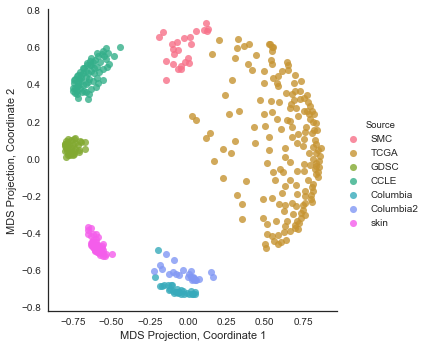

In [15]:
#MDS Plot pre ComBat
def visualize(df,lib=False,type='mds',path='../Figures/7DataBanks_PreCombat.pdf'): 
    sns.set()
    sns.set_style("white")
    if type=='mds':
        X = df.values
        X_std=StandardScaler().fit_transform(X)
        similarities = 1-np.corrcoef(X_std)#
        mds = manifold.MDS(n_components=2, max_iter=1000, eps=1e-9,
                       dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        clf = PCA(n_components=2)
        pos = clf.fit_transform(pos)

        dfad=pd.DataFrame(dict(coor1=pos[:,0], coor2=pos[:,1], Source=lib))

        g=sns.lmplot('coor1', 'coor2', data=dfad, \
             hue='Source',scatter_kws={"s": 50}, fit_reg=False)
        g.set_axis_labels('MDS Projection, Coordinate 1', 'MDS Projection, Coordinate 2')
        g.savefig(path)
visualize(df.T,lib=lib,type='mds')

In [16]:
#Read in batch identified data - in this case, 1:SMC, 2:TCGA. 3:GDSC, 4:CCLE, and 5:Columbia1, 
#6:Columbia2, and 7:Skin. 

#NOTE: this data, henceforth refered to as 'dft', does not contain covariate columns of anykind.
#If it did, and reference batches are to be used, these columns must be used to generate a model
#matrix (example below) and the columns must be dropped from 'dft' in the main code where specified.

dft = pd.read_csv('C:/Users/Moime/Notebooks/dftdb')
dft.set_index(['Where'], inplace = True)
dft.head()

,SAMD11,NOC2L,KLHL17,C1orf170,HES4,ISG15,AGRN,C1orf159,TNFRSF18,TNFRSF4,...,COL6A2,FTCD,LSS,MCM3AP,C21orf58,PCNT,DIP2A,S100B,PRMT2,batch
Where,,,,,,,,,,,,,,,,,,,,,
SMC,0.364132,0.445353,0.652705,-0.010895,0.957592,0.929392,0.632646,0.214291,2.801627,0.983457,...,0.839435,0.963090,1.217365,-1.200449,-1.118236,-1.358750,0.157147,1.115086,-0.092972,1
SMC.1,0.795285,0.659201,0.876646,0.591207,1.082755,0.951817,0.825705,0.357369,2.875071,-0.260166,...,1.091446,0.743005,1.554801,-1.052765,-1.083522,-1.162942,0.338110,1.110806,-0.039749,1
SMC.2,-0.979639,-0.452990,0.424425,-0.525859,1.726114,-0.633115,0.263594,-0.451811,0.495825,-0.130609,...,-0.654603,0.174496,0.426504,-0.984997,0.789553,-1.310878,-0.622702,1.152245,-0.412858,1
SMC.3,-1.118480,0.612895,0.024682,-0.889757,2.782449,1.232234,0.420186,0.009926,1.488598,1.663609,...,0.685454,0.356024,0.431256,-1.388397,0.116714,-1.604019,-0.990420,1.206256,-0.460032,1
SMC.4,0.181047,0.658627,2.840539,-0.248175,1.950163,1.041246,0.574922,1.073334,0.952868,-0.153962,...,0.155120,0.985977,0.793351,-0.289350,0.033380,-0.259933,1.041978,0.552608,-0.322007,1


In [17]:
dft.shape

(406, 12515)

In [18]:
#If using covariates, identify them here in the "" position. If not, can simply let mod argument = 
#None in Combat function.
mod = patsy.dmatrix("",dft, return_type="dataframe")

In [19]:
#Using mean only and CCLE as ref_batch, for example:
cmdf = combat(df,dft.batch, None, None, True, 4)

found 7 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
C:\Users\Moime\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
Finding parametric adjustments
C:\Users\Moime\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


Adjusting data


C:\Users\Moime\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [20]:
cmdf.head()

,SMC,SMC.1,SMC.2,SMC.3,SMC.4,SMC.5,SMC.6,SMC.7,SMC.8,SMC.9,...,skin.CP66-MEL,skin.451Lu,skin.HT-144,skin.SK-MEL-2,skin.LB2518-MEL,skin.LB373-MEL-D,skin.Hs940-T,skin.SK-MEL-31,skin.CP50-MEL-B,skin.COLO-829
SAMD11,1.056784,1.487937,-0.286987,-0.425828,0.873699,1.358860,0.157857,0.444978,1.496912,1.718942,...,0.703630,0.578062,0.403783,0.227970,0.694430,0.641290,0.904055,0.896189,0.720546,0.789908
NOC2L,-1.339139,-1.125291,-2.237482,-1.171597,-1.125865,-0.253647,-1.010589,-0.979506,-0.374372,-0.631776,...,-0.813708,-0.969074,-0.965157,-0.903766,-0.731082,-0.756075,-0.991040,-1.153115,-1.010056,-1.293830
KLHL17,-0.770503,-0.546562,-0.998784,-1.398526,1.417331,1.055230,1.145825,0.545160,1.096463,-0.663077,...,-0.078361,-0.061727,-0.221169,-0.224138,-0.086722,-0.148834,0.025839,-0.222733,-0.350785,-0.374836
C1orf170,1.106389,1.708491,0.591424,0.227527,0.869109,2.453052,1.694925,0.824079,1.817465,0.556955,...,1.167021,1.244789,0.837166,0.893188,1.077141,0.618798,0.900263,0.725909,0.626473,0.876178
HES4,-0.861100,-0.735937,-0.092578,0.963757,0.131470,0.239205,0.221897,-0.483627,0.165878,0.324819,...,-0.006439,0.165742,-0.454645,-0.249744,-0.730662,-0.606956,1.157529,-1.258629,-1.050086,-0.753404


In [21]:
df.head()

,SMC,SMC.1,SMC.2,SMC.3,SMC.4,SMC.5,SMC.6,SMC.7,SMC.8,SMC.9,...,skin.CP66-MEL,skin.451Lu,skin.HT-144,skin.SK-MEL-2,skin.LB2518-MEL,skin.LB373-MEL-D,skin.Hs940-T,skin.SK-MEL-31,skin.CP50-MEL-B,skin.COLO-829
SAMD11,0.364132,0.795285,-0.979639,-1.118480,0.181047,0.666208,-0.534795,-0.247674,0.804260,1.026290,...,-0.231799,-0.357368,-0.531647,-0.707460,-0.240999,-0.294140,-0.031374,-0.039241,-0.214884,-0.145521
NOC2L,0.445353,0.659201,-0.452990,0.612895,0.658627,1.530846,0.773903,0.804986,1.410121,1.152716,...,0.958621,0.803255,0.807171,0.868563,1.041246,1.016254,0.781288,0.619213,0.762273,0.478499
KLHL17,0.652705,0.876646,0.424425,0.024682,2.840539,2.478438,2.569034,1.968369,2.519671,0.760132,...,-0.416816,-0.400182,-0.559624,-0.562594,-0.425178,-0.487289,-0.312617,-0.561188,-0.689241,-0.713291
C1orf170,-0.010895,0.591207,-0.525859,-0.889757,-0.248175,1.335769,0.577642,-0.293204,0.700181,-0.560329,...,-0.856626,-0.778858,-1.186481,-1.130459,-0.946506,-1.404849,-1.123384,-1.297738,-1.397174,-1.147469
HES4,0.957592,1.082755,1.726114,2.782449,1.950163,2.057898,2.040590,1.335065,1.984570,2.143511,...,0.064753,0.236934,-0.383453,-0.178553,-0.659470,-0.535764,1.228721,-1.187438,-0.978894,-0.682213


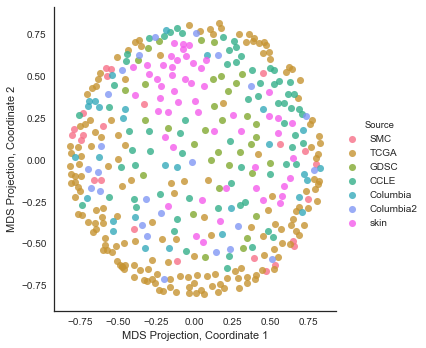

In [22]:
#MDS Plot post combat
def visualize(cmdf,lib=False,type='mds',path='../Figures/7DataBanks_PostComBat_MeanOnly_ref_batchCCLE.pdf'): 
    sns.set()
    sns.set_style("white")
    if type=='mds':
        X = cmdf.values
        X_std=StandardScaler().fit_transform(X)
        similarities = 1-np.corrcoef(X_std)#
        mds = manifold.MDS(n_components=2, max_iter=1000, eps=1e-9,
                       dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        clf = PCA(n_components=2)
        pos = clf.fit_transform(pos)

        dfad=pd.DataFrame(dict(coor1=pos[:,0], coor2=pos[:,1], Source=lib))

        g=sns.lmplot('coor1', 'coor2', data=dfad, \
             hue='Source',scatter_kws={"s": 50}, fit_reg=False)
        g.set_axis_labels('MDS Projection, Coordinate 1', 'MDS Projection, Coordinate 2')
        g.savefig(path)
visualize(cmdf.T,lib=lib,type='mds')

In [23]:
#Spearman Correlation
sp_corr=[]
names=[]
for j in df.columns:
        x=df[j].values.tolist()
        y=cmdf[j].values.tolist()
        r=sc.stats.spearmanr(x,y)
        sp_corr.append(r[0])
        names.append(j)

In [24]:
ds=pd.Series(sp_corr,names)

In [25]:
print(ds.idxmin(),ds.idxmax())
ds.describe()

TCGA.11 CCLE


count    406.000000
mean       0.422154
std        0.316761
min        0.019025
25%        0.160023
50%        0.349193
75%        0.696746
max        1.000000
dtype: float64

In [26]:
#See which things are most similar
ds[(ds <=1.) & (ds>.7) ]

GDSC       0.704708
GDSC.2     0.703506
GDSC.4     0.708431
GDSC.5     0.708994
GDSC.6     0.701803
GDSC.7     0.702246
GDSC.8     0.706086
GDSC.9     0.700552
GDSC.10    0.703305
GDSC.12    0.701327
GDSC.13    0.701167
GDSC.14    0.702233
GDSC.15    0.707094
GDSC.16    0.701902
GDSC.17    0.704444
GDSC.18    0.703221
GDSC.19    0.709059
GDSC.21    0.701154
GDSC.22    0.711197
GDSC.24    0.702911
GDSC.26    0.709269
GDSC.27    0.703003
GDSC.28    0.704549
GDSC.29    0.700341
GDSC.30    0.704709
GDSC.31    0.704621
GDSC.32    0.709451
GDSC.33    0.710552
GDSC.34    0.704840
CCLE       1.000000
             ...   
CCLE.39    1.000000
CCLE.40    1.000000
CCLE.41    1.000000
CCLE.42    1.000000
CCLE.43    1.000000
CCLE.44    1.000000
CCLE.45    1.000000
CCLE.46    1.000000
CCLE.47    1.000000
CCLE.48    1.000000
CCLE.49    1.000000
CCLE.50    1.000000
CCLE.51    1.000000
CCLE.52    1.000000
CCLE.53    1.000000
CCLE.54    1.000000
CCLE.55    1.000000
CCLE.56    1.000000
CCLE.57    1.000000
